# Library

In [47]:
#Basic statistic & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

#Geographic Information
import geopy.distance

#Preprocessing
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

#Modeling
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.utils import plot_model

# Problem Statement

**Background**

<p style='text-align: justify;'>Uber is an American app-based transportation platform headquartered in San Francisco, California who develop an app that connects drivers to users who need a ride, using a smartphone as a tool. The Uber Business Model is also known as a Multisided Platform Business Model, as it connects drivers (offer) and passengers (demand), in order to offer cheaper transportation and an additional source of income. 
The customer must use the Uber app to book a ride and then enter the customer's destination before the trip takes place. When the customer arrives at the destination, the journey ends. Fares are automatically calculated and charged to the payment method the customer connects to the Uber account.

**Problem**

<p style='text-align: justify;'>One of the biggest problem from Uber as ride hailing company is availability of drivers at certain times (rush hours or bad weather conditions) and certain locations in some cities. The best way to solve that problems is use Surge Pricing. Surge Pricing / Dynamic Pricing (Flexible Pricing) is where prices change constantly based on market fluctuations. For that, Uber need system and algorithm to make prediction for fare amount based on some feature on history data.

**Goals**

<p style='text-align: justify;'>The goals of this analysis are to know the price per transaction according to particular conditions (the time, distance traveled, etc) so surge pricing can be applied.

# Data Understanding

## Load Dataset

In [48]:
df_raw = pd.read_csv("uber.csv")
df_raw.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


**Feature Description**

* key: A unique identifier for each trip.
* fare_amount: The cost of each trip in usd.
* pickup_datetime: Date and time when the meter was engaged.
* passenger_count: The number of passengers in the vehicle (driver entered value).
* pickup_longitude: The longitude where the meter was engaged.
* pickup_latitude: The latitude where the meter was engaged.
* dropoff_longitude: The longitude where the meter was disengaged.
* dropoff_latitude: The latitude where the meter was disengaged.

In [49]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


## Drop Unique Feature

In [50]:
df = df_raw.drop(columns=["Unnamed: 0","key"])
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [51]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


## Change Data Type

In [52]:
df['pickup_datetime'] = df['pickup_datetime'].map(lambda x: x.lstrip('').rstrip(' UTC'))

df["pickup_datetime"]=pd.to_datetime(df["pickup_datetime"])
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   fare_amount        200000 non-null  float64       
 1   pickup_datetime    200000 non-null  datetime64[ns]
 2   pickup_longitude   200000 non-null  float64       
 3   pickup_latitude    200000 non-null  float64       
 4   dropoff_longitude  199999 non-null  float64       
 5   dropoff_latitude   199999 non-null  float64       
 6   passenger_count    200000 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 10.7 MB


# Feature Engineering

## Missing Value

In [54]:
df.isna().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [55]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   fare_amount        199999 non-null  float64       
 1   pickup_datetime    199999 non-null  datetime64[ns]
 2   pickup_longitude   199999 non-null  float64       
 3   pickup_latitude    199999 non-null  float64       
 4   dropoff_longitude  199999 non-null  float64       
 5   dropoff_latitude   199999 non-null  float64       
 6   passenger_count    199999 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 12.2 MB


## Extract Date Feature

In [56]:
df["year"]=df["pickup_datetime"].dt.year
df["month"]=df["pickup_datetime"].dt.month
df["day"]=df["pickup_datetime"].dt.day
df["hour"]=df["pickup_datetime"].dt.hour
df["minute"]=df["pickup_datetime"].dt.minute

df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,minute
0,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,52
1,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,4
2,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,45
3,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,22
4,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,47


## Extract Weekend Variable

In [57]:
is_weekend = []
for i in range(0,len(df["pickup_datetime"])):
    is_weekend.append(df["pickup_datetime"].iloc[i].weekday())
df["day_name"] = is_weekend

df["is_weekend"] = np.where(df["day_name"]<5,0,1)

df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,minute,day_name,is_weekend
0,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,52,3,0
1,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,4,4,0
2,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,45,0,0
3,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,22,4,0
4,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,47,3,0


## Extract Week Variable

In [58]:
week_list = []

for i in range(0,(len(df))):
    if df["day"].iloc[i]<=7:
        week_list.append(1)
    elif df["day"].iloc[i]<=14:
        week_list.append(2)
    elif df["day"].iloc[i]<=21:
        week_list.append(3)
    elif df["day"].iloc[i]>21:
        week_list.append(4)

df["week"] = week_list
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,minute,day_name,is_weekend,week
0,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,52,3,0,1
1,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,4,4,0,3
2,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,45,0,0,4
3,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,22,4,0,4
4,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,47,3,0,4


## Identify Latitude Feature

In [59]:
df[(df["pickup_latitude"]>90) | (df["dropoff_latitude"]>90)]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,minute,day_name,is_weekend,week
56617,8.1,2012-03-11 07:24:00,-73.960828,404.433332,-73.988357,40.769037,1,2012,3,11,7,24,6,1,2
61793,8.5,2012-06-13 05:45:00,-73.951385,401.066667,-73.982110,40.754117,1,2012,6,13,5,45,2,0,2
75851,15.7,2011-11-05 00:22:00,-1340.648410,1644.421482,-3356.666300,872.697628,1,2011,11,5,0,22,5,1,1
91422,16.1,2011-05-18 13:24:00,57.418457,1292.016128,1153.572603,-881.985513,1,2011,5,18,13,24,2,0,3
139447,13.7,2012-01-20 11:50:00,-74.011042,40.709780,-73.983163,493.533332,4,2012,1,20,11,50,4,0,3


In [60]:
lat90 = list(df[(df["pickup_latitude"]>90) | (df["dropoff_latitude"]>90)].index)
df.drop(lat90,inplace = True)

## Extract Distance Variable

In [61]:
distance=[]

for i in range(0,(len(df))):
    dist = geopy.distance.geodesic((df["pickup_latitude"].iloc[i],df["pickup_longitude"].iloc[i]), (df["dropoff_latitude"].iloc[i],df["dropoff_longitude"].iloc[i])).km
    distance.append(round(dist,2))

In [62]:
df["distance"]=distance

In [63]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,minute,day_name,is_weekend,week,distance
0,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,52,3,0,1,1.68
1,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,4,4,0,3,2.45
2,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,45,0,0,4,5.04
3,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,22,4,0,4,1.66
4,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,47,3,0,4,4.48



## Import Dataframe to CSV

In [64]:
df.to_csv(r'C:\Users\juan.suwardi\Documents\Personal Project\Deep Learning\Regression\Uber Fare\Dataset_uber.csv')

# Exploratory Data Analysis (EDA)

## Data Distribution

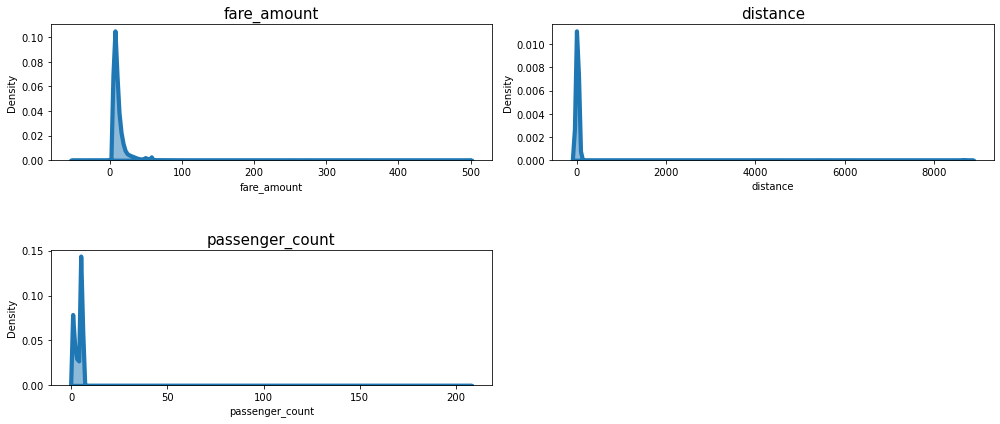

In [18]:
num = ["fare_amount","distance","passenger_count"]

plt.figure(figsize=(14,6))
a = 1
for i in num:
    plt.subplot(ceil(len(num)/2),2,a)
    plt.title(i,fontsize=15)
    sns.kdeplot(df[i],shade=True, alpha=.5, linewidth=4.2)
    a+=1
    plt.tight_layout(h_pad=4)

## Data Correlation

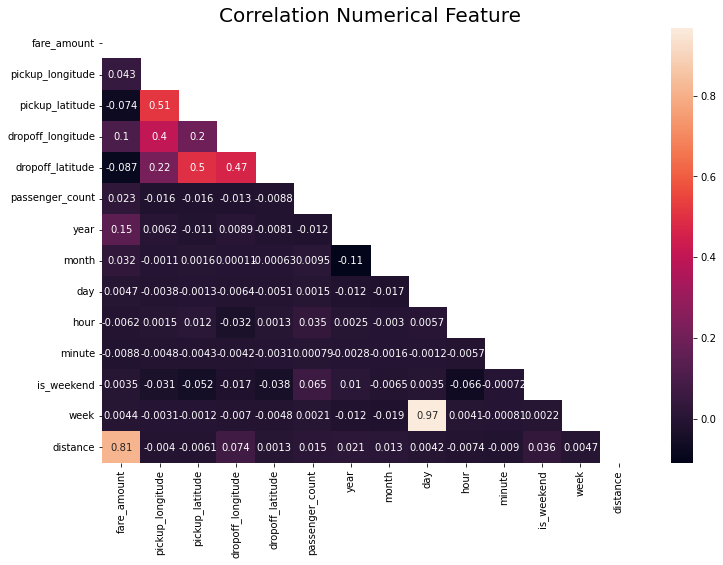

In [19]:
num_list = list(df.describe().columns)

plt.figure(figsize=(12,8))
#Masking
mask = np.triu(np.ones_like(df[num_list].corr()))
sns.heatmap(df[num_list].corr("spearman"),annot=True,mask=mask)
plt.title("Correlation Numerical Feature",fontsize=20)
plt.show()

## Boxplot

C:\Users\vanessa.gabriella\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vanessa.gabriella\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vanessa.gabriella\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.w

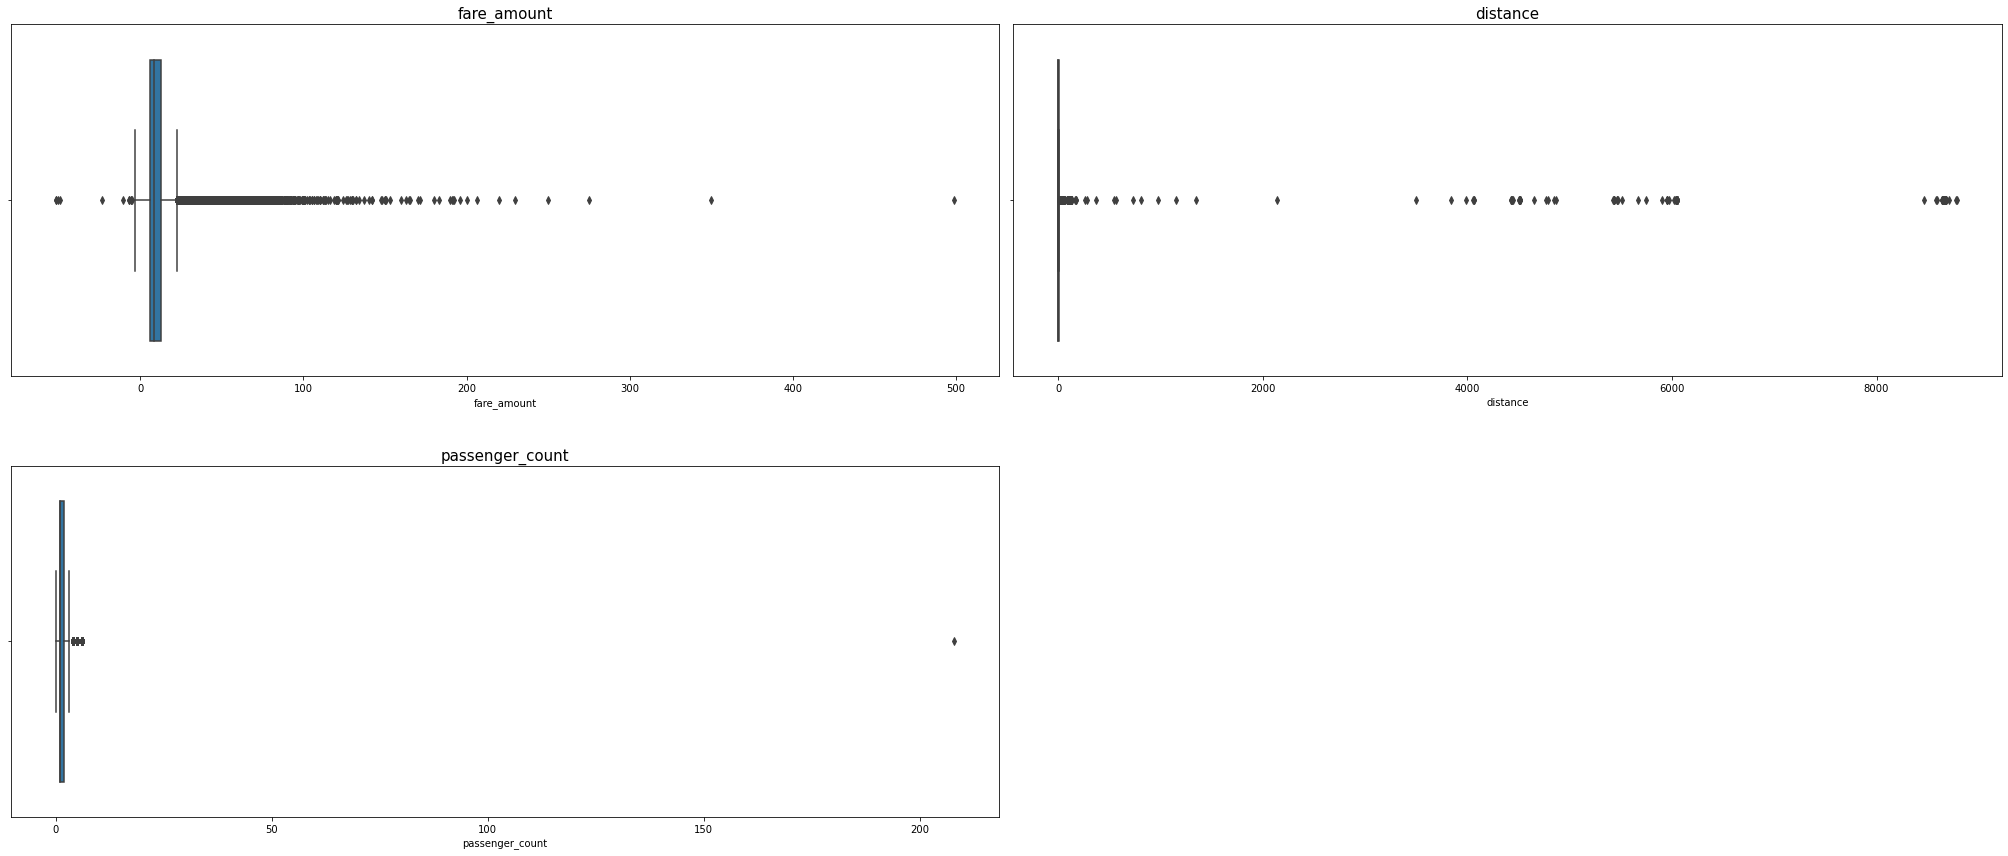

In [20]:
plt.figure(figsize=(28,12))
a = 1
for i in num:
    plt.subplot(ceil(len(num)/2),2,a)
    plt.title(i,fontsize=15)
    sns.boxplot(df[i])
    a+=1
    plt.tight_layout(h_pad=4)

In [21]:
def tot_outlier(feat):
    df[feat].describe().loc[["25%","50%","75%"]]
    Q1 = df[feat].describe().loc["25%"]
    Q2 = df[feat].describe().loc["50%"]
    Q3 = df[feat].describe().loc["75%"]
    IQR = Q3-Q1
    Blw = Q1 - (1.5*IQR)
    Up = Q3 + (1.5*IQR)
    print((df[feat]>Up).sum() + (df[feat]<Blw).sum())

In [22]:
#Number outliers of distance
tot_outlier("distance")

16832


In [23]:
#Number outliers of distance
tot_outlier("passenger_count")

22556


# Preprocessing

In [24]:
df_mod = df[["fare_amount","passenger_count","month","day","hour","minute","distance"]]

In [25]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199994 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   fare_amount      199994 non-null  float64
 1   passenger_count  199994 non-null  int64  
 2   month            199994 non-null  int64  
 3   day              199994 non-null  int64  
 4   hour             199994 non-null  int64  
 5   minute           199994 non-null  int64  
 6   distance         199994 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 16.2 MB


## Outliers Isolation

In [26]:
df_iso = df_mod.copy()

clf = IsolationForest( random_state = 42)
clf.fit(df_iso)
y_noano = clf.predict(df_iso)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

df_iso = df_iso.iloc[y_noano[y_noano['Top'] == 1].index.values]
df_iso.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", df_iso.shape[0])

Number of Outliers: 48218
Number of rows without outliers: 151776


## Transform

In [27]:
transformer= ColumnTransformer([
    ("minmax",MinMaxScaler(),list(df_mod.drop(columns = "fare_amount").columns)),
], remainder='passthrough')

## Splitting

### Normal Dataset

In [28]:
x = df_mod.drop(columns=["fare_amount"])
y = df_mod["fare_amount"]

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    random_state=2020)

In [29]:
x_train_t = transformer.fit_transform(x_train)
x_test_t = transformer.fit_transform(x_test)

### Outliers isolation

In [30]:
x_iso = df_iso.drop(columns=["fare_amount"])
y_iso = df_iso["fare_amount"]

x_train_iso, x_test_iso, y_train_iso, y_test_iso = train_test_split(
    x_iso,
    y_iso,
    random_state=2020)

In [31]:
x_train_iso_t = transformer.fit_transform(x_train_iso)
x_test_iso_t = transformer.fit_transform(x_test_iso)

# Change Dataset to Tensor

In [33]:
x_train_t = tf.constant(x_train_t)
x_test_t = tf.constant(x_test_t)

In [34]:
x_train_iso_t = tf.constant(x_train_iso_t)
x_test_iso_t = tf.constant(x_test_iso_t) 

# Data Analytics

## Fare Amount with Distance

In [39]:
df[(df["distance"]==5.9)].sort_values('distance',ascending = False).head(10)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,minute,is_weekend,week,distance
61,17.3,2011-10-30 11:34:39,-73.975307,40.757499,-74.010737,40.711715,3,2011,10,30,11,34,1,4,5.9
159355,19.3,2009-10-01 22:28:54,-74.002254,40.708987,-73.986314,40.760759,1,2009,10,1,22,28,0,1,5.9
156550,18.5,2015-06-10 00:02:06,-73.990837,40.760738,-74.004944,40.708679,1,2015,6,10,0,2,0,2,5.9
149807,16.5,2012-08-22 19:18:56,-74.015900,40.711541,-73.977034,40.755639,1,2012,8,22,19,18,0,4,5.9
148028,17.0,2014-01-11 19:35:00,-73.966872,40.753402,-74.007062,40.709982,1,2014,1,11,19,35,1,2,5.9
144744,16.5,2010-07-23 08:22:00,-73.982830,40.751273,-74.014377,40.703863,1,2010,7,23,8,22,0,4,5.9
143663,14.5,2012-06-06 22:41:00,-73.992277,40.724570,-73.975910,40.776250,5,2012,6,6,22,41,0,1,5.9
140696,13.3,2009-07-28 00:10:41,-73.961068,40.661146,-74.021339,40.634483,1,2009,7,28,0,10,0,4,5.9
136159,18.1,2011-03-09 23:11:00,-73.958185,40.816093,-73.924282,40.769667,5,2011,3,9,23,11,0,2,5.9
133393,16.5,2014-03-22 12:48:00,-73.981710,40.773367,-73.923867,40.743587,1,2014,3,22,12,48,1,4,5.9


In [44]:
print(f'''Maximum value at distance 5.9: {df[(df["distance"]==5.9)]['fare_amount'].max()}
Minimum value at distance 5.9: {df[(df["distance"]==5.9)]['fare_amount'].min()}''')

Maximum value at distance 5.9: 29.0
Minimum value at distance 5.9: 9.7


We can see if the price are different although they have same distance with max value of fare amount is 29 and min value of fare amount is 9.7 

## Visualization with Tableau

Source: https://public.tableau.com/app/profile/juan1691/viz/UberTransactionAnalysis/UberTransactionsAnalysis?publish=yes

### Dashboard 1: Orders Informations

<img src='db1.png'>

Filter:
* Day: Sunday
* Week: 1
* Month: 1
* Year: 2015

With result:
* Number of orders on sunday: 52.
* Avarage passangers on sunday: 2.
* There is no difference of number of orders between weekend and not weekend.
* Day 10 have the highest number of orders than other days.
* Week 4 have the highest number of orders than other days.
* 2013 have the highest number of orders than other years.

### Dashboard 2: Transactions Activity

<img src='db22.png'>

Filter:
* Year: 2015
* Month: January
* Week: 1

With results:
* Saturday have the most transactions than others days.
* 7 am  is the time with the most transactions than others hours on Sunday.
* Friday have the longest distance traveled compared to other days.
* 3 am is the time with the longest distance traveled than others hours on Sunday.
* Friday have the biggest revenue compared to other days.
* 1 pm is the time with the biggest revenue than others hours on Sunday.

### Dashboard 3: Transactions Summary

<img src='db3.png'>

This results based on all data:

* June have the longest total distance traveled compared to other months.
* 2014 have the longest total distance traveled compared to other years.
* May have the highest revenue compared to other months.
* 2013 have the highest revenue compared to other years.

### Dashboard 4: Transactions History

<img src='db4.png'>

Filter:
* Year: 2015
* Month: January
* Date: 1
* Hour: 7 - 11
* Transactions code: 180500

With result:
* Distance: 1.170 km
* Fare Amount: 5 USD
* Number of Passangers: 2
* Map: Pickup & Dropoff

# Modeling

## Visialization Function

### Loss

In [45]:
def loss(x):
    plt.plot(x.history['loss'])
    plt.plot(x.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc=0)
    plt.show()

### Loss with Learning Rate

In [46]:
def loss_lr(x):
    plt.plot(x.history['loss'])
    plt.plot(x.history['val_loss'])
    plt.plot(x.history['lr'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc=0)
    plt.show()

### Loss VS Learning Rate

In [47]:
#Plot the learning rate vs Loss
def lr_plot(x):
    lrs = 1e-4 * 10**(tf.range(len(x.history['loss']))/20)
    plt.figure(figsize=(10,7))
    plt.semilogx(lrs,x.history['loss'])
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")
    plt.title("Learning Rate VS Loss")

## Basic Model

### Create Model

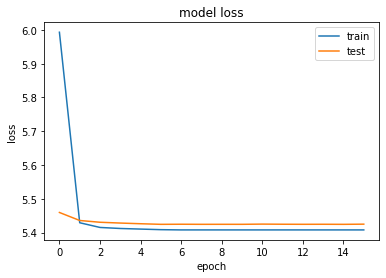

In [48]:
#Set Random Seed
tf.random.set_seed(42)

#Create Model
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
],name = 'whole_dataset')

#Compiling Model
model_1.compile(loss= "mae",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

#Callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

#Fitting Model
history1 = model_1.fit(tf.expand_dims(x_train_t,axis=-1),y_train,epochs=100,validation_split=0.3,batch_size = 32,callbacks=[callback],verbose = 0)

loss(history1)

In [49]:
df_1 = pd.DataFrame(history1.history).sort_values("val_mae",ascending=True).head()
df_1

,loss,mae,val_loss,val_mae
14,5.408067,5.408067,5.424577,5.424577
5,5.408801,5.408801,5.424587,5.424587
7,5.408074,5.408074,5.424617,5.424617
9,5.408065,5.408065,5.424631,5.424631
8,5.408060,5.408060,5.424667,5.424667


### Summary

#### Prediction

In [50]:
bas = model_1.evaluate(x_test_t,y_test,batch_size=32)

1563/1563 [==============================] - 3s 2ms/step - loss: 5.3849 - mae: 5.3849


#### Weight

In [51]:
model_1.layers[0].get_weights()[0]

array([[-0.00631716]], dtype=float32)

#### Bias

In [52]:
model_1.layers[0].get_weights()[1]

array([8.477627], dtype=float32)

#### Model Summary

In [53]:
model_1.summary()

Model: "whole_dataset"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6, 1)              2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


## Isolation Outliers Dataset

### Create Model

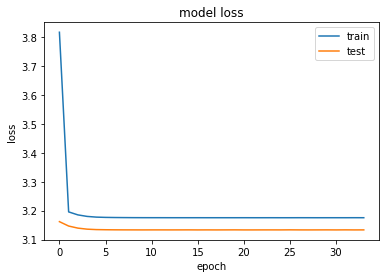

In [54]:
#Set Random Seed
tf.random.set_seed(42)

#Create Model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
],name='isolation_dataset')

#Compiling Model
model_2.compile(loss= "mae",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])
#Callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

#Fitting Model
history2 = model_2.fit(tf.expand_dims(x_train_iso_t,axis=-1),y_train_iso,epochs=100,validation_split=0.3,batch_size = 32,callbacks=[callback],verbose = 0)

loss(history2)

In [55]:
df_2 = pd.DataFrame(history2.history).sort_values("val_mae",ascending=True).head()
df_2

,loss,mae,val_loss,val_mae
17,3.175559,3.175559,3.133450,3.133450
21,3.175535,3.175535,3.133453,3.133453
15,3.175592,3.175592,3.133454,3.133454
20,3.175587,3.175587,3.133455,3.133455
32,3.175624,3.175624,3.133459,3.133459


### Summary

#### Prediction

In [56]:
bas_out = model_2.evaluate(x_test_t,y_test,batch_size=32)

1563/1563 [==============================] - 4s 2ms/step - loss: 5.4182 - mae: 5.4182


#### Model Summary

In [57]:
model_2.summary()

Model: "isolation_dataset"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6, 1)              2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


#### Weight

In [58]:
model_2.layers[0].get_weights()[0]

array([[0.71378404]], dtype=float32)

#### Bias

In [59]:
model_2.layers[0].get_weights()[1]

array([7.5694532], dtype=float32)

## Change Optimizer

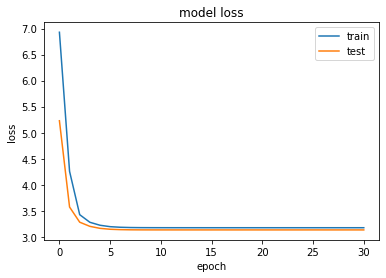

In [60]:
#Set Random Seed
tf.random.set_seed(42)

#Create Model
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

#Compiling Model
model_3.compile(loss= "mae",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])

#Callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

#Fitting Model
history3 = model_3.fit(tf.expand_dims(x_train_iso_t,axis=-1),y_train_iso,epochs=40,validation_split=0.3,batch_size = 32,callbacks=[callback],verbose = 0)
loss(history3)

In [61]:
df_3 = pd.DataFrame(history3.history).sort_values("val_mae",ascending=True).head()
df_3

,loss,mae,val_loss,val_mae
17,3.175527,3.175527,3.133448,3.133448
30,3.175532,3.175532,3.133452,3.133452
20,3.175549,3.175549,3.133454,3.133454
15,3.175583,3.175583,3.133456,3.133456
18,3.175551,3.175551,3.133458,3.133458


## Add Activation

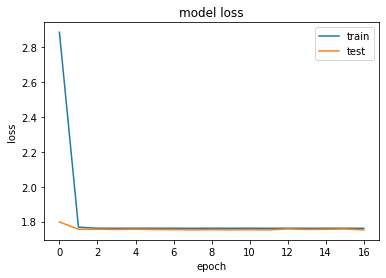

In [62]:
#Set Random Seed
tf.random.set_seed(42)

#Create Model
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(10,input_shape=[6],name="input_layer"),
    tf.keras.layers.Dense(1)
])

#Compiling Model
model_5.compile(loss= tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])

#Callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

#Fitting Model
history5 = model_5.fit(tf.expand_dims(x_train_iso_t,axis=-1),y_train_iso,epochs=40,validation_split=0.3,batch_size = 32,callbacks=[callback],verbose = 0)

loss(history5)

In [63]:
df_5 = pd.DataFrame(history5.history).sort_values("val_mae",ascending=True).head()
df_5

,loss,mae,val_loss,val_mae
16,1.760983,1.760983,1.751723,1.751723
9,1.761316,1.761316,1.751917,1.751917
11,1.760978,1.760978,1.752041,1.752041
7,1.761003,1.761003,1.752194,1.752194
8,1.761451,1.761451,1.752942,1.752942


## Change Activation

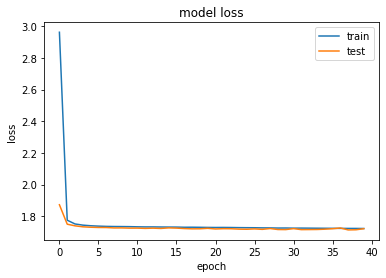

In [64]:
#Set Random Seed
tf.random.set_seed(42)

#Create Model
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(10,input_shape=[6], activation='relu',name="input_layer"),
    tf.keras.layers.Dense(1)
])

#Compiling Model
model_6.compile(loss= tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])

#Callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

#Fitting Model
history6 = model_6.fit(tf.expand_dims(x_train_iso_t,axis=-1),y_train_iso,epochs=40,validation_split=0.3,batch_size = 32,callbacks=[callback],verbose = 0)

loss(history6)

In [65]:
df_6 = pd.DataFrame(history6.history).sort_values("val_mae",ascending=True).head()
df_6

,loss,mae,val_loss,val_mae
37,1.723926,1.723926,1.714500,1.714500
38,1.723852,1.723852,1.715493,1.715493
31,1.725958,1.725958,1.716329,1.716329
29,1.726486,1.726486,1.716552,1.716552
32,1.725586,1.725586,1.716768,1.716768


## Add Hidden Layer

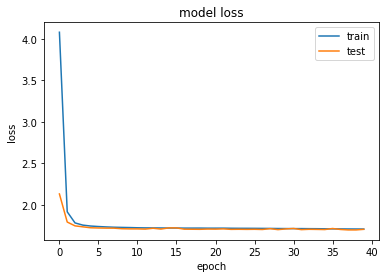

In [66]:
#Set Random Seed
tf.random.set_seed(42)

#Create Model
model_7 = tf.keras.Sequential([
    tf.keras.layers.Dense(10,input_shape=[6], activation='relu',name="input_layer"),
    tf.keras.layers.Dense(10, activation='sigmoid'),
    tf.keras.layers.Dense(1,name="output_layer")
])

#Compiling Model
model_7.compile(loss= tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])

#Callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

#Fitting Model
history7 = model_7.fit(tf.expand_dims(x_train_iso_t,axis=-1),y_train_iso,epochs=40,validation_split=0.3,batch_size = 32,callbacks=[callback],verbose = 0)

loss(history7)

In [67]:
df_7 = pd.DataFrame(history7.history).sort_values("val_mae",ascending=True).head()
df_7

,loss,mae,val_loss,val_mae
38,1.709494,1.709494,1.698475,1.698475
37,1.709827,1.709827,1.698515,1.698515
28,1.715281,1.715281,1.701945,1.701945
31,1.714303,1.714303,1.702038,1.702038
34,1.711926,1.711926,1.702863,1.702863


## Add Number of Epochs

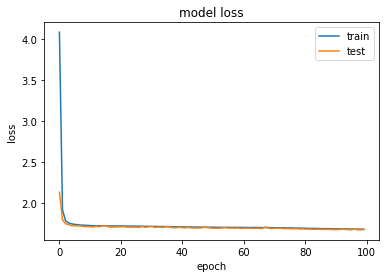

In [68]:
#Set Random Seed
tf.random.set_seed(42)

#Create Model
model_8 = tf.keras.Sequential([
    tf.keras.layers.Dense(10,input_shape=[6], activation='relu',name="input_layer"),
    tf.keras.layers.Dense(10, activation='sigmoid'),
    tf.keras.layers.Dense(1,name="output_layer")
],name = 'neural_network_isolation')

#Compiling Model
model_8.compile(loss= tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])

#Callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

#Fitting Model
history8 = model_8.fit(tf.expand_dims(x_train_iso_t,axis=-1),y_train_iso,epochs=100,validation_split=0.3,batch_size = 32,callbacks=[callback],verbose = 0)

loss(history8)

In [69]:
df_8 = pd.DataFrame(history8.history).sort_values("val_mae",ascending=True).head()
df_8

,loss,mae,val_loss,val_mae
98,1.681334,1.681334,1.671631,1.671631
97,1.682088,1.682088,1.672622,1.672622
95,1.682653,1.682653,1.673387,1.673387
94,1.683146,1.683146,1.673949,1.673949
99,1.681038,1.681038,1.675065,1.675065


## Adjust Learning Rate

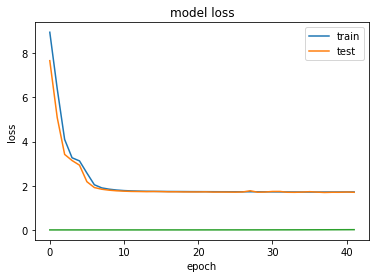

In [70]:
#Set Random Seed
tf.random.set_seed(42)

#Create Model
model_10 = tf.keras.Sequential([
    tf.keras.layers.Dense(10,input_shape=[6], activation='relu',name="input_layer"),
    tf.keras.layers.Dense(10, activation='sigmoid'),
    tf.keras.layers.Dense(1,name="output_layer")
],name = 'neural_network_isolation')

#Compiling Model
model_10.compile(loss= tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])

#Callbacks
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

#Fitting Model
history10 = model_10.fit(tf.expand_dims(x_train_iso_t,axis=-1),y_train_iso,
                       epochs=100,
                       validation_split=0.3,
                       batch_size = 32,
                       callbacks=[callback,lr_scheduler],verbose = 0)

loss_lr(history10)

In [71]:
df_10 = pd.DataFrame(history10.history).sort_values("val_mae",ascending=True).head()
df_10

,loss,mae,val_loss,val_mae,lr
37,1.716605,1.716605,1.695637,1.695637,0.007079
33,1.718291,1.718291,1.702608,1.702608,0.004467
41,1.719083,1.719083,1.704262,1.704262,0.011220
39,1.717610,1.717610,1.704416,1.704416,0.008913
38,1.717350,1.717350,1.704880,1.704880,0.007943


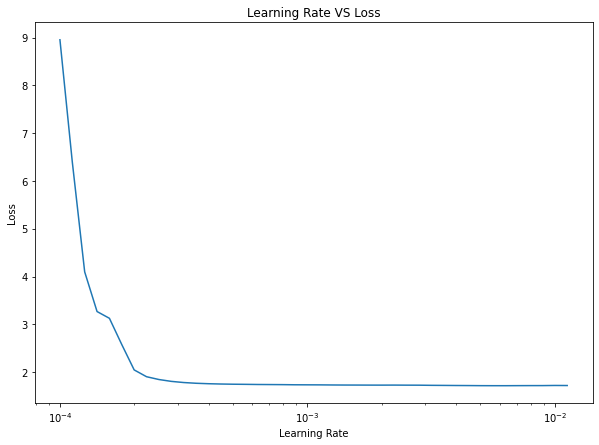

In [72]:
lr_plot(history10)

lr = 0.002

## Model Neural Network

### Create Model

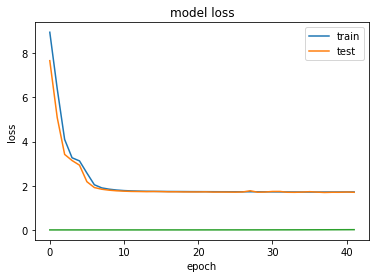

In [73]:
#Set Random Seed
tf.random.set_seed(42)

#Create Model
model_11 = tf.keras.Sequential([
    tf.keras.layers.Dense(10,input_shape=[6], activation='relu',name="input_layer"),
    tf.keras.layers.Dense(10, activation='sigmoid'),
    tf.keras.layers.Dense(1,name="output_layer")
],name = 'neural_network_isolation')

#Compiling Model
model_11.compile(loss= tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.002),
              metrics=["mae"])

#Callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

#Fitting Model
history11 = model_11.fit(tf.expand_dims(x_train_iso_t,axis=-1),y_train_iso,
                       epochs=100,
                       validation_split=0.3,
                       batch_size = 32,
                       callbacks=[callback,lr_scheduler],verbose = 0)

loss_lr(history11)

In [74]:
df_11 = pd.DataFrame(history11.history).sort_values("val_mae",ascending=True).head()
df_11

,loss,mae,val_loss,val_mae,lr
37,1.716605,1.716605,1.695637,1.695637,0.007079
33,1.718291,1.718291,1.702608,1.702608,0.004467
41,1.719083,1.719083,1.704262,1.704262,0.011220
39,1.717610,1.717610,1.704416,1.704416,0.008913
38,1.717350,1.717350,1.704880,1.704880,0.007943


### Prediction

In [75]:
mod_dl = model_8.evaluate(x_test_iso_t,y_test_iso,batch_size=32)

1186/1186 [==============================] - 3s 2ms/step - loss: 1.6891 - mae: 1.6891


### Model Summary

In [76]:
model_8.summary()

Model: "neural_network_isolation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 10)                70        
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 output_layer (Dense)        (None, 1)                 11        
                                                                 
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________


### Weight

In [77]:
for i in range (0,3):
    print('Layer',i, '\n', model_8.layers[i].get_weights()[0])

Layer 0 
 [[ 0.18637276  0.4807637  -0.16423497 -0.14139692 -0.18676859  0.02521471
   0.0806458   0.705507    0.18631546 -0.0315196 ]
 [-0.01472896 -0.06530108 -0.09515627 -0.01496782  0.0546421   0.05843709
  -0.6875039  -0.13193183  0.35912922  0.03696295]
 [-0.01801087 -0.014326   -0.19615686  0.06950525  0.23439562 -0.00733078
  -0.07291232 -0.07757045  0.7908447   0.52076465]
 [ 0.05150546  0.14956507  0.2671324  -0.07386474  0.45696533 -2.4647362
   0.2047946   0.95191693 -0.00955687  0.77462757]
 [ 0.00975376  0.18583408 -0.12932135 -0.57467455  0.0928778  -0.08206505
  -0.06010519 -0.10915121  0.45307413  0.42962205]
 [ 5.1030407   3.2972925   6.241628    0.16736083  2.4239604  -0.03727419
  -0.22682865 -2.2131557   3.303217   -2.8653705 ]]
Layer 1 
 [[ 5.949696    0.02202791 -0.4414134   0.9824892   0.5293645   2.832041
   0.9137709  -0.39413413 -0.12470625  0.67840046]
 [ 0.891274    0.5605026  -0.97553885  0.16391344  0.44455647  0.86845154
  -2.2547002  -0.9862008  -0.0775

### Bias

In [78]:
for i in range (0,3):
    print('Layer',i, '\n', model_8.layers[i].get_weights()[1])

Layer 0 
 [-0.18956625  0.18793     0.3278069  -0.1295419  -0.13150875  1.1865779
 -0.19791345  1.0671521  -0.14179766  1.1229757 ]
Layer 1 
 [ 0.5541392  -0.84105617  0.48964983 -0.07017602 -0.8234742  -0.07896383
 -1.3375953   0.5912529  -1.5023296  -0.57169044]
Layer 2 
 [2.800778]


# Hyperparameter Tuning

## Tuning

In [96]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=[6]))

    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=50, max_value=80, step=5)
    model.add(keras.layers.Dense(units=hp_units,input_shape=[6], activation='relu',name="input_layer"))
    model.add(keras.layers.Dense(units=hp_units, activation='sigmoid'))
    model.add(keras.layers.Dense(1,name="output_layer"))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[2e-3,2e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="mae",
                metrics=['mae'])

    return model

In [97]:
tuner = kt.Hyperband(model_builder,
                     objective='mae',
                     max_epochs=10,
                     factor=5,
                     seed = 46,
                    project_name="Uber Model Tuner 6")
stop_early = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=5)

In [98]:
tuner.search(x_train_iso_t, y_train_iso, epochs=200, validation_split=0.3)

Trial 13 Complete [00h 00m 57s]
mae: 1.755517601966858

Best mae So Far: 1.706892490386963
Total elapsed time: 00h 05m 55s
INFO:tensorflow:Oracle triggered exit


## Modeling

### Create Model

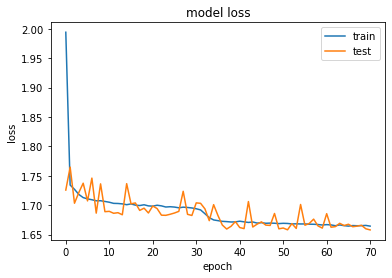

In [94]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

history9 = model.fit(tf.expand_dims(x_train_iso_t,axis=-1),y_train_iso,epochs=200,validation_split=0.3,batch_size = 32,callbacks=[callback],verbose = 0)
loss(history9)

In [95]:
df_9 = pd.DataFrame(history9.history).sort_values("val_mae",ascending=True).head()
df_9

,loss,mae,val_loss,val_mae
70,1.664504,1.664504,1.658057,1.658057
51,1.669038,1.669038,1.658253,1.658253
37,1.672197,1.672197,1.659563,1.659563
49,1.668805,1.668805,1.659920,1.659920
69,1.665726,1.665726,1.659995,1.659995


## Summary

### Prediction

In [84]:
mod_tun= model.evaluate(x_test_iso_t,y_test_iso,batch_size=32)

1186/1186 [==============================] - 2s 2ms/step - loss: 1.6539 - mae: 1.6539


### Model Summary

In [85]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 6)                 0         
                                                                 
 input_layer (Dense)         (None, 70)                490       
                                                                 
 dense_10 (Dense)            (None, 70)                4970      
                                                                 
 output_layer (Dense)        (None, 1)                 71        
                                                                 
Total params: 5,531
Trainable params: 5,531
Non-trainable params: 0
_________________________________________________________________


### Weight

In [86]:
for i in range (1,4):
    print('Layer',i, '\n', model.layers[i].get_weights()[0])

Layer 1 
 [[ 2.87467360e-01  1.39730871e-02 -1.82816386e-03 -1.64536583e+00
   3.85010630e-01  2.74978038e-02 -1.28144860e-01 -6.21851563e-01
  -3.28990877e-01 -4.45942938e-01  4.22376573e-01 -3.13484818e-01
   3.28292370e-01  4.39652890e-01 -5.93340397e-03 -4.69242096e-01
  -3.58036160e-01  3.04494590e-01 -2.68723100e-01 -1.78051859e-01
   5.94555318e-01 -1.45483166e-02  3.87715369e-01  2.18801111e-01
  -2.54276097e-01 -1.21191159e-01 -3.75290424e-01 -2.44511534e-02
   5.94888985e-01 -4.42777574e-01  1.25847794e-02 -9.03303623e-01
  -1.07146896e-01 -4.05209064e-01  3.45793515e-01 -6.01451993e-01
  -7.27583319e-02 -4.03565884e-01  3.14923137e-01 -1.46950018e+00
  -1.61915272e-01  1.65685982e-01  4.09111977e-01 -2.90002316e-01
  -6.61009625e-02 -1.90685108e-01 -1.67102233e-01 -3.94459933e-01
   6.71142191e-02 -4.74912822e-01 -8.39020871e-03 -6.51879162e-02
  -4.50110659e-02  1.67949628e-02 -5.93219325e-02  9.84318275e-03
   2.97840722e-02  1.37034893e-01  1.28541943e-02 -9.72176529e-03


### Bias

In [87]:
for i in range (1,4):
    print('Layer',i, '\n', model.layers[i].get_weights()[1])

Layer 1 
 [-0.0057222   0.          0.         -0.33212334 -0.26273748  0.26437637
 -0.48047316 -0.47631598 -0.3366896  -0.6467133  -0.11042116 -0.11208092
 -0.7976151  -0.5678693  -0.11661078 -0.26878652 -0.22391443 -0.0837907
  0.         -0.37488294 -0.41392586 -0.24008086 -0.8085182   0.36365515
  0.5003955   0.29308724  0.52644515 -0.06125917 -0.46411267  0.08457462
  0.09987684 -0.15447657  0.6366609  -0.5196564  -0.47575772 -0.7502107
  0.         -0.32070762 -0.49121565  0.15570018 -0.31319922  0.58181435
 -0.13772762 -0.36083287 -0.23343217 -0.4690709  -0.59547883  0.05310728
 -0.10602173 -0.38828546 -0.09091198 -0.28867176 -0.19512835 -0.09414731
  0.6161854  -0.6382219  -0.20623246 -0.32544976 -0.07606771  0.60810584
 -0.18303995 -0.40666038 -0.698018   -0.4389269   0.68888044 -0.22995283
 -0.0265429  -0.29083523  0.         -0.27007982]
Layer 2 
 [-0.08222561 -0.7373324  -0.28702408 -0.71825045 -0.65013635 -0.4436669
 -0.2103687  -0.81505257 -0.07210346 -0.11249226 -0.39239

# Prediction Result

In [88]:
df_res = x_test_iso
df_res["Prediction"] = (model.predict(x_test_iso_t))
df_res['Fare_Amount'] = y_test_iso
df_res.tail(10)

,passenger_count,month,day,hour,minute,distance,Prediction,Fare_Amount
63650,2,7,19,11,29,2.63,9.752669,12.0
132680,2,2,27,15,50,1.13,5.676755,4.5
51701,1,7,9,6,44,0.90,4.450456,4.0
58343,1,5,18,6,45,0.77,4.250412,4.1
27373,2,5,26,23,33,0.68,4.271000,3.3
101780,1,7,12,11,53,2.72,9.834371,10.0
124436,1,9,11,22,48,1.24,5.533067,10.5
57811,1,3,12,17,2,1.12,5.555438,6.5
132720,1,9,1,16,42,3.25,10.706995,10.5
105048,1,3,13,14,13,4.09,12.859071,14.0


# Conclusion

## Summary Model

In [89]:
pd.DataFrame({'Model':["Basic Neural Network","Basic Neural Network Isolation","Neural Network Isolation","Neural Network Isolation Tuned"],
            'MAE Data Train':[df_1['mae'].iloc[0],df_2['mae'].iloc[0],df_8['mae'].iloc[0],df_9['mae'].iloc[0]],
            'MAE Data Validation':[df_1['val_mae'].iloc[0],df_2['val_mae'].iloc[0],df_8['val_mae'].iloc[0],df_9['val_mae'].iloc[0]],
            'MAE Data Test': [bas[1],bas_out[1],mod_dl[1],mod_tun[1]]
             }).set_index('Model')

,MAE Data Train,MAE Data Validation,MAE Data Test
Model,,,
Basic Neural Network,5.408067,5.424577,5.384887
Basic Neural Network Isolation,3.175559,3.133450,5.418192
Neural Network Isolation,1.681334,1.671631,1.689075
Neural Network Isolation Tuned,1.665117,1.656574,1.653926


In [90]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 6)                 0         
                                                                 
 input_layer (Dense)         (None, 70)                490       
                                                                 
 dense_10 (Dense)            (None, 70)                4970      
                                                                 
 output_layer (Dense)        (None, 1)                 71        
                                                                 
Total params: 5,531
Trainable params: 5,531
Non-trainable params: 0
_________________________________________________________________


## Business Insight

With this algorithm, Company can determine fare amount not only based on distance, but can be day or time so the price more suitable for consumer, driver, and company.

With data analytics, we found:
* 2012 have the most transaction than others years.
* 2013 have the most revenue than others years.
* There is no difference between weekday and weekend
* Saturday have the most transactions than others days.

## Recommendation

* With deep learning, we cant determine how model works, so we need model to describe what factor which have more effect tp fare amount.
* More feature like city, holiday, event, etc can help to make model more accureate.